In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [2]:
import torchvision.datasets


In [4]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

len(y_train), len(y_test)

(60000, 10000)

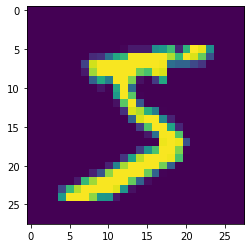

tensor(5)


In [5]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])


In [6]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [7]:
X_train.shape


torch.Size([60000, 1, 28, 28])

In [27]:
# Опишем класс

class LeNetMod5(torch.nn.Module):
    
    
    # конструктор
    def __init__(self, activation='tanh', pooling='avg',
                conv_size=5, use_batch_norm=False):
        super(LeNetMod5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        
        elif activation == 'relu':
            activation_function = torch.nn.ReLU()
        
        else:
            raise NotImplementedError
            # Исключение, возникающее в случаях, 
#             когда наследник класса не переопределил метод, 
#             который должен был
        
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        elif pooling == 'max':
            pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)
            
        else:
            raise NotImplementedError
            
            
        # здесь выбираем, что принимать: 1 свертку 5*5 или 2 свертки  3*3
            
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
            
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
            in_channels=6, out_channels=6, kernel_size=3, padding=1)
            
        else:
            raise NotImplementedError
            
            
        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6) # передаем количество каналов перед нормализацией
        self.pool1 = pooling_layer
        
        
        if conv_size == 5:
            self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
            
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
            in_channels=16, out_channels=16, kernel_size=3, padding=0)
            
        else:
            raise NotImplementedError
        
        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5*5*16, 120)
        self.act3 = activation_function
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
        
        
    def forward(self, x):
        
        # 1 слой
        
        if self.conv_size == 5:
            x = self.conv1(x)
            
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x)) # 2 свертки, записанны вложенно
            
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        
        x = self.pool1(x)
        
        # 2 слой
        
        if self.conv_size == 5:
            x = self.conv2(x)
            
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
            
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        
        x = self.pool2(x)
        
        # 3 слой, вытягиваем вектор для слоя fc
        
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        
        # 4 слой
        
        x = self.fc2(x)
        x = self.act4(x)
        
        # 5 слой
        
        x = self.fc3(x)
        
        return x

In [28]:
# функция тренировки

# используем флажки train и eval.Зачем?
# Дело в том, что batch_norm происходит в момент forward, 
# то есть каждый раз у нас высчитываются и подгоняются параметры, для
# этого мы batch_norm говорим, что сеть не обучается, а мы ее тестируем,
# чтобы он не изменял параметры мат ожидания и стандартного отклонения,
# иначе параметры будут меняться

def train(net, X_train, y_train, X_test, y_test):
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size=100
    
    test_accuracy_history = []
    test_loss_history = []
    
    for epoch in range(10):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            # флажок, сеть находится в состоянии тренировки
            net.train()
            
            batch_indexes = order[start_index : start_index + batch_size]
            
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            preds = net.forward(X_batch)
            
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            optimizer.step()
        
        # флажок, сеть находится в состоянии eval
        net.eval()
        
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data)
        
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
        test_accuracy_history.append(accuracy)
        
        print(accuracy)
    print('-------------')
    return test_accuracy_history, test_loss_history

In [29]:
# создаем словари

accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train(LeNetMod5(activation='tanh', conv_size=5), 
         X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNetMod5(activation='relu', conv_size=5), 
         X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNetMod5(activation='relu', conv_size=3), 
         X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNetMod5(activation='relu', conv_size=3, pooling='max'), 
         X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNetMod5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
         X_train, y_train, X_test, y_test)

tensor(0.9772)
tensor(0.9827)
tensor(0.9829)
tensor(0.9842)
tensor(0.9845)
tensor(0.9863)
tensor(0.9883)
tensor(0.9886)
tensor(0.9869)
tensor(0.9879)
-------------
tensor(0.9824)
tensor(0.9880)
tensor(0.9886)
tensor(0.9895)
tensor(0.9905)
tensor(0.9911)
tensor(0.9889)
tensor(0.9882)
tensor(0.9911)
tensor(0.9887)
-------------
tensor(0.9829)
tensor(0.9825)
tensor(0.9839)
tensor(0.9901)
tensor(0.9880)
tensor(0.9898)
tensor(0.9914)
tensor(0.9872)
tensor(0.9874)
tensor(0.9897)
-------------
tensor(0.9824)
tensor(0.9862)
tensor(0.9862)
tensor(0.9866)
tensor(0.9871)
tensor(0.9906)
tensor(0.9877)
tensor(0.9879)
tensor(0.9869)
tensor(0.9880)
-------------
tensor(0.9792)
tensor(0.9839)
tensor(0.9809)
tensor(0.9892)
tensor(0.9890)
tensor(0.9877)
tensor(0.9881)
tensor(0.9896)
tensor(0.9916)
tensor(0.9892)
-------------


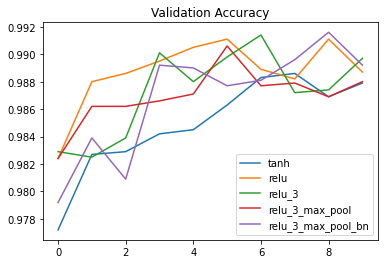

In [30]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

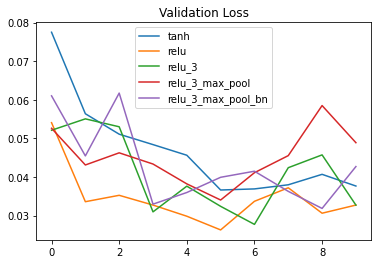

In [32]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');